# We will be using Keras, pretty much the highest-level neural network API.  It can use tensorflow, CNTK, or theano as a backend.  If tensorflow is using a GPU, then it is using the NVIDIA CUDA codebase (another API), which then is calling nearly direct commands on the GPU.  So we could have 3 levels of APIs if we are using Keras on a GPU.

data from here: https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset

In [15]:
import pandas as pd
import numpy as np

In [3]:
filename = 'hour.csv'
# parse dates will convert those columns (labels in the list) to dates

# infer datetime format will try to figure out the datetime format of the dates columns
# and keep using that for the column, so can speed up loading by a lot sometimes
bike_df = pd.read_csv(filename, parse_dates=['dteday'], infer_datetime_format=True)
bike_df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [5]:
# drops the record index 'instant' and date
# also drop casual and registered, because cnt = casual + registered
drop_cols = ['instant', 'dteday', 'casual', 'registered']
bike_df.drop(drop_cols, axis=1, inplace=True)
# if you want, you could engineer more features by getting the day of the month or other properties from the date

In [6]:
bike_df.describe()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,189.463088
std,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,181.387599
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,40.000000
50%,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,142.000000
75%,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,281.000000
max,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,977.000000


In [7]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 13 columns):
season        17379 non-null int64
yr            17379 non-null int64
mnth          17379 non-null int64
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weathersit    17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
cnt           17379 non-null int64
dtypes: float64(4), int64(9)
memory usage: 1.7 MB


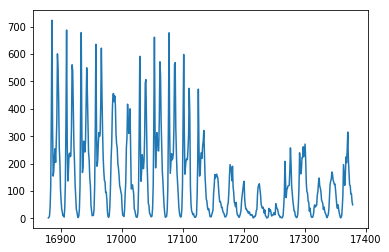

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
_ = bike_df['cnt'].iloc[-500:].plot()

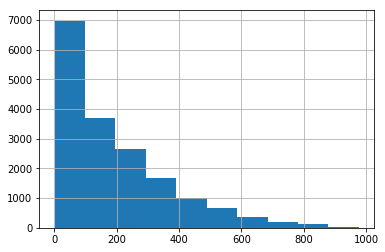

In [9]:
_ = bike_df['cnt'].hist()

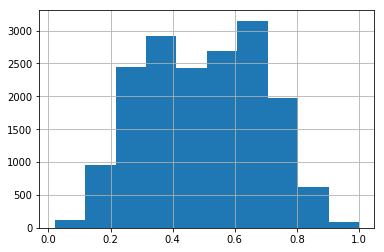

In [10]:
_ = bike_df['temp'].hist()

# 'cnt' is what we are trying to predict.  This is the number of people who rented bikes during that hour.

In [11]:
bike_df.shape

(17379, 13)

In [12]:
cols = bike_df.columns
feat_cols = [c for c in cols if c != 'cnt']
features = bike_df[feat_cols].values
targets = bike_df['cnt'].values

# for time series we typically want to save the last bit as the testing instead of mixing up the timesteps
trainsize = round(0.8 * features.shape[0])
train_features = features[:trainsize]
test_features = features[trainsize:]
train_targets = targets[:trainsize]
test_targets = targets[trainsize:]
print(train_targets.shape)
print(test_targets.shape)

(13903,)
(3476,)


In [13]:
# force to use CPU for testing
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [16]:
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.models import Model, load_model
import keras.backend as K
from keras.callbacks import ModelCheckpoint

In [17]:
features.shape[1]

12

In [18]:
# creates the model

# restart keras session (clear weights), sometimes this will clear up errors
K.clear_session()

# functional API
inputs = Input(shape=(features.shape[1], ))
x1 = Dense(10, activation='elu')(inputs)
x2 = BatchNormalization()(x1)
x3 = Dropout(0.5)(x2)
x = Dense(1, activation='linear')(x3)

In [19]:
# this compiles our model so it is ready to fit
model = Model(inputs, x)
model.compile(optimizer='adam', loss='mse')

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 12)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                130       
_________________________________________________________________
batch_normalization_1 (Batch (None, 10)                40        
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 181
Trainable params: 161
Non-trainable params: 20
_________________________________________________________________


In [21]:
train_features.shape

(13903, 12)

In [22]:
# this can be used to select only a small amount of data
# trainsize is the full training size
subset_size = trainsize
train_feature_subset = train_features[:subset_size]
train_target_subset = train_targets[:subset_size]
# we actually fit the model here
history = model.fit(train_feature_subset,
                    train_target_subset,
                    epochs=500,
                    validation_split=0.15,
                    batch_size=1000)

Train on 11817 samples, validate on 2086 samples
Epoch 1/500
11817/11817 [==============================] - 1s 45us/step - loss: 46712.5116 - val_loss: 123195.7710
Epoch 2/500
11817/11817 [==============================] - 0s 2us/step - loss: 46663.6165 - val_loss: 123000.7094
Epoch 3/500
11817/11817 [==============================] - 0s 2us/step - loss: 46607.9243 - val_loss: 122807.8391
Epoch 4/500
11817/11817 [==============================] - 0s 2us/step - loss: 46567.0506 - val_loss: 122615.5332
Epoch 5/500
11817/11817 [==============================] - 0s 2us/step - loss: 46518.4815 - val_loss: 122424.4672
Epoch 6/500
11817/11817 [==============================] - 0s 2us/step - loss: 46458.9911 - val_loss: 122237.4953
Epoch 7/500
11817/11817 [==============================] - 0s 2us/step - loss: 46404.7363 - val_loss: 122053.1931
Epoch 8/500
11817/11817 [==============================] - 0s 2us/step - loss: 46356.5358 - val_loss: 121873.8831
Epoch 9/500
11817/11817 [=============

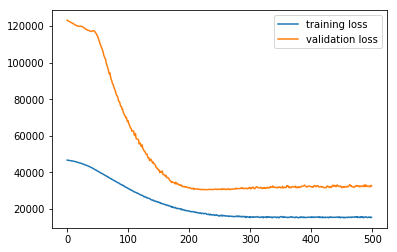

In [23]:
# check losses for overfitting and performance
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.legend()
plt.show()

0.0
0.45290648140492873


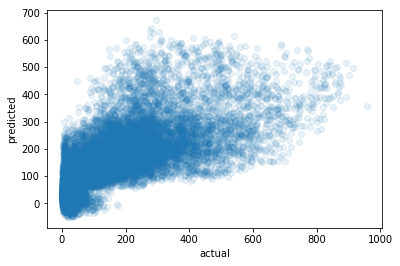

In [24]:
past_preds = model.predict(train_features)[:, 0]
future_preds = model.predict(test_features)[:, 0]

from sklearn.metrics import r2_score
import numpy as np

# our benchmark is just guessing the average
benchmark = np.mean(train_targets)
print(r2_score(train_targets, [benchmark] * train_targets.shape[0]))

print(r2_score(train_targets, past_preds))
plt.scatter(train_targets, past_preds, alpha=0.1)
plt.xlabel('actual')
plt.ylabel('predicted')
plt.show()

-0.11299526466191145
0.4150353967958995


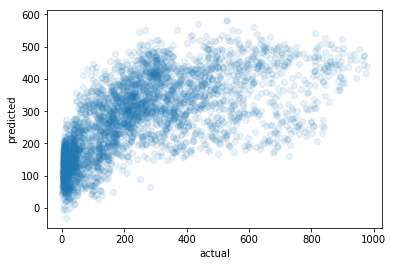

In [25]:
print(r2_score(test_targets, [benchmark] * test_targets.shape[0]))

print(r2_score(test_targets, future_preds))
plt.scatter(test_targets, future_preds, alpha=0.1)
plt.xlabel('actual')
plt.ylabel('predicted')
plt.show()

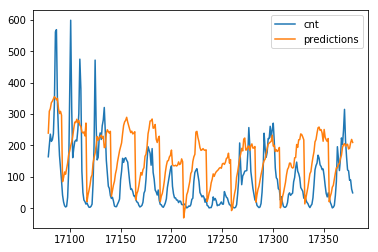

In [26]:
bike_df['cnt'].iloc[-300:].plot()
plt.plot(bike_df.index[-300:], future_preds[-300:], label='predictions')
_ = plt.legend()

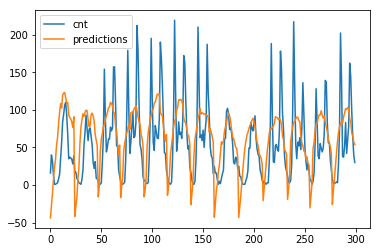

In [25]:
bike_df['cnt'].iloc[:300].plot()
plt.plot(bike_df.index[:300], past_preds[:300], label='predictions')
_ = plt.legend()

# now your turn: try different network hyperparameter settings and see which is best.  Recommendations:

* Change activation functions https://keras.io/activations/
* Change layer sizes
* Change number of layers
* Change dropout rate 
* loss function https://keras.io/losses/

Only do these one at a time.  Don't change network size, activation function, dropout rate all at the same time, or you wont know what made your net better or worse.

Advanced things to try:
* regularization (to prevent overfitting) https://keras.io/regularizers/
* mess around with optimizers https://keras.io/optimizers/
* use sklearn's StandardScaler to z-scale all your features http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html